In [40]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.colab import files
uploaded = files.upload()

Saving 202501.xlsx to 202501 (2).xlsx


In [41]:
# 데이터 불러오기
df = pd.read_excel('202501.xlsx')

In [42]:
# 금속 컬럼 추출
metal_columns = df.columns[df.columns.str.endswith('(ng/m3)')]

In [43]:
# 시간 데이터로 변환 (Pump-Begin 기준)
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'])

In [44]:
# 음수값 Nan 처리
df[metal_columns] = df[metal_columns].applymap(lambda x: x if x >= 0 else np.nan)

/tmp/ipython-input-2225207843.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[metal_columns] = df[metal_columns].applymap(lambda x: x if x >= 0 else np.nan)


In [45]:
# 단위 변환: ng/m³ → µg/m³
df[metal_columns] = df[metal_columns] / 1000.0

In [46]:
# 날짜 컬럼 생성 (datetime을 date로 변환)
df['Date'] = df['Pump-Begin'].dt.date

# 날짜 분할 (11일 단위)
unique_dates = sorted(df['Date'].unique())
chunks = [unique_dates[i:i+11] for i in range(0, len(unique_dates), 11)]

In [47]:
# 금속 총합 계산
df['Metal_Total'] = df[metal_columns].sum(axis=1)

In [48]:
# 금속을 총합 기준으로 정렬
metal_sums = df[metal_columns].sum().sort_values(ascending=False)  # 내림차순
metal_columns_sorted = metal_sums.index.tolist()  # 금속 컬럼 리스트 정렬

/tmp/ipython-input-1743576796.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(metal_columns_sorted))


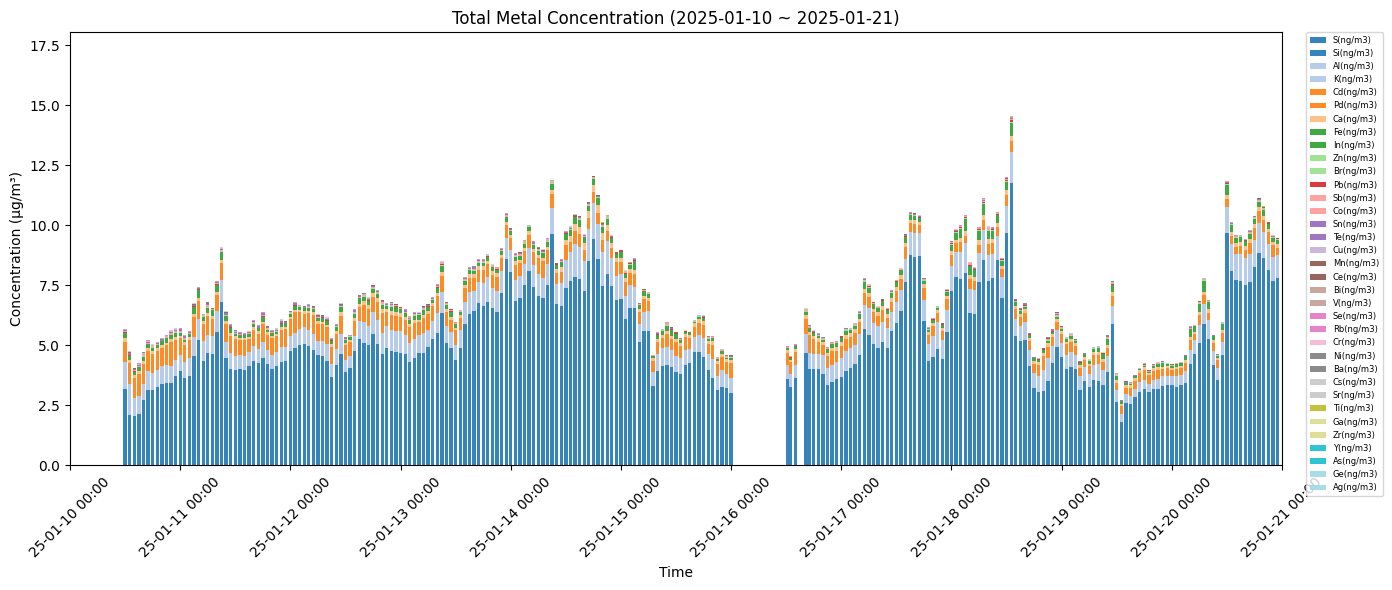

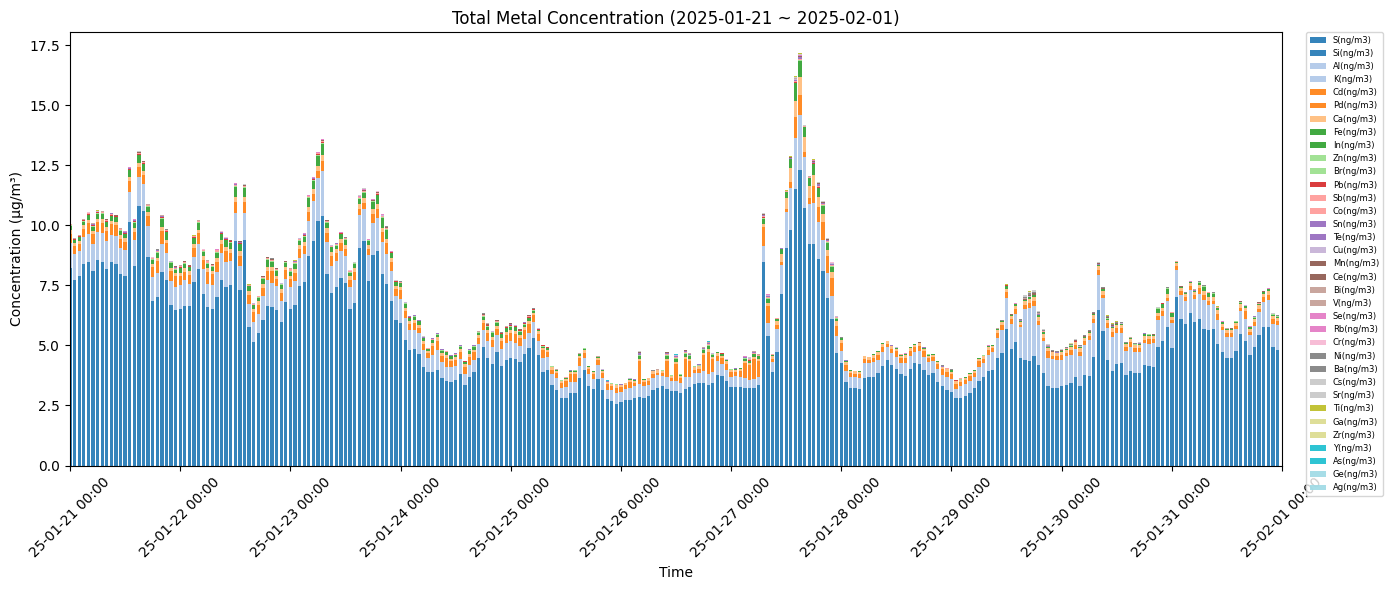

In [49]:
# 전체 데이터 기준 y축 최대값 계산
total_all = df[metal_columns_sorted].fillna(0).sum(axis=1).to_numpy()
global_ymax = float(np.nanmax(total_all)) * 1.05

# 색상 팔레트 (정렬된 금속 순서에 맞춰 고정)
cmap = cm.get_cmap('tab20', len(metal_columns_sorted))
palette = [cmap(i) for i in range(len(metal_columns_sorted))]

# 금속 총합 누적 막대그래프 생성
for date_group in chunks:
    start_date = pd.to_datetime(min(date_group))
    end_date = pd.to_datetime(max(date_group)) + pd.Timedelta(hours=24)

    temp_df = (df[df['Date'].isin(date_group)]
              .loc[lambda x: (x['Pump-Begin'] >= start_date) & (x['Pump-Begin'] <= end_date)]
              .sort_values('Pump-Begin')
              .reset_index(drop=True))

    plt.figure(figsize=(14, 6))
    bottom_values = pd.Series(0.0, index=temp_df.index)

    bars = []   # 범례 고정
    labels = metal_columns_sorted

    # 금속 순서 및 색상 설정
    for idx, metal_col in enumerate(metal_columns_sorted):
        heights = temp_df[metal_col].fillna(0).to_numpy()
        bar = plt.bar(temp_df['Pump-Begin'],
                      heights,
                      bottom=bottom_values.to_numpy(),
                      width=0.03,
                      color=palette[idx],
                      alpha=0.9)
        bottom_values += heights
        bars.append(bar)

    # 그래프 기본 설정
    plt.title(f'Total Metal Concentration ({start_date.date()} ~ {end_date.date()})')
    plt.xlabel('Time')
    plt.ylabel('Concentration (µg/m³)')

    # x축, y축 설정
    plt.xlim(start_date, end_date)
    plt.ylim(0, global_ymax)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
    plt.xticks(rotation=45)

    # 범례 고정
    plt.legend([b[0] for b in bars], labels,
               loc='upper left', bbox_to_anchor=(1.02, 1),
           fontsize=6, ncol=1, borderaxespad=0)

    # 그래프 출력
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-2207358662.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(metal_columns_sorted))


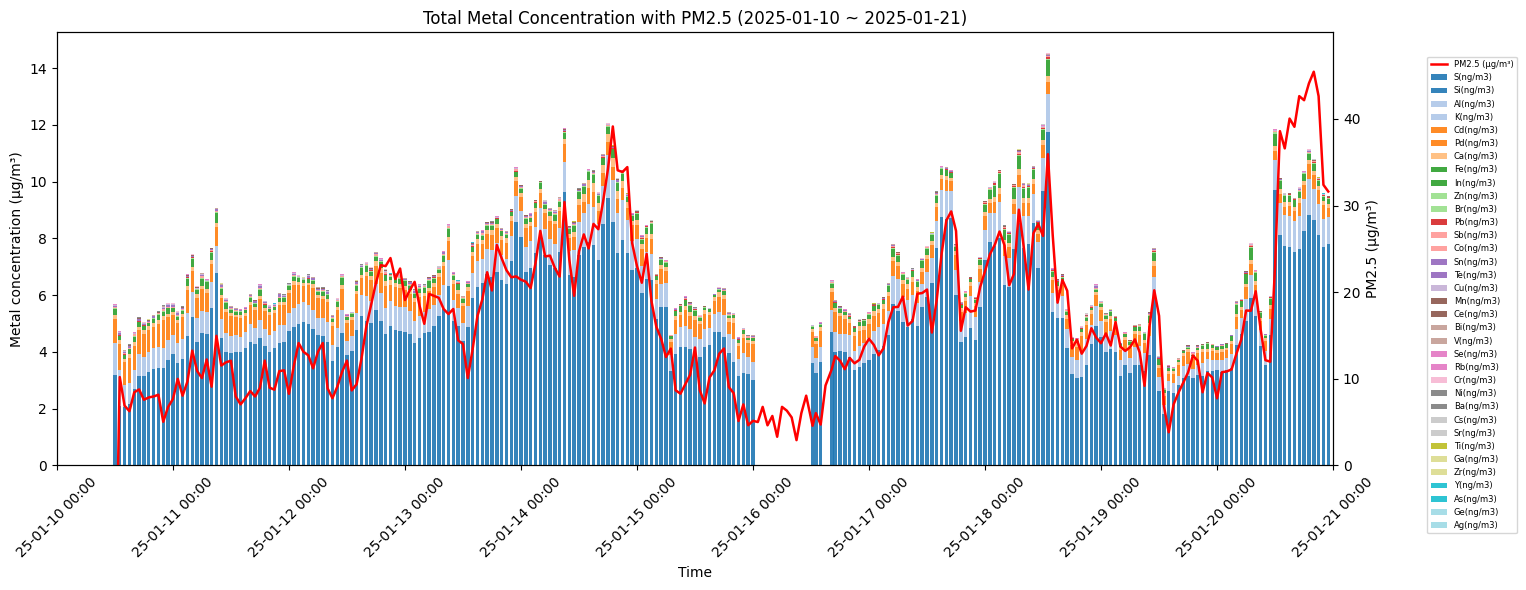

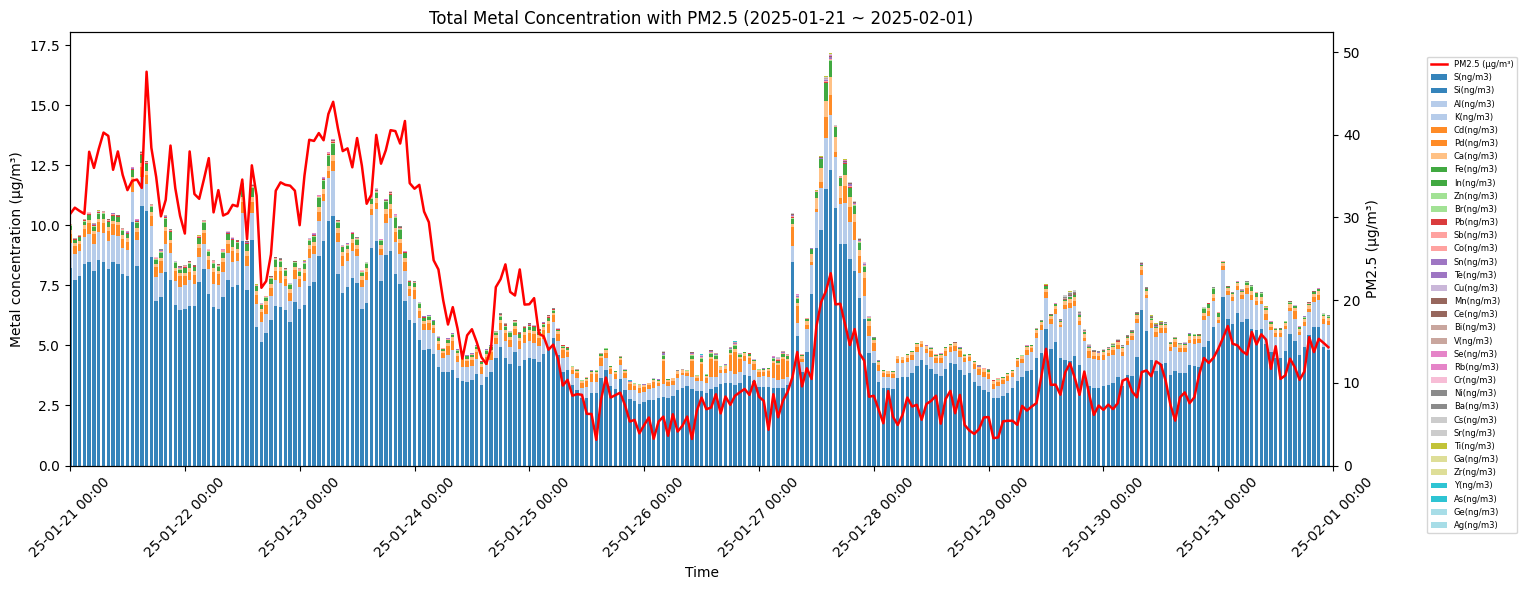

In [60]:
# 전체 데이터 기준 y축 최대값 계산
total_all = df[metal_columns_sorted].fillna(0).sum(axis=1).to_numpy()
global_ymax = float(np.nanmax(total_all)) * 1.05

# 색상 팔레트 (정렬된 금속 순서에 맞춰 고정)
cmap = cm.get_cmap('tab20', len(metal_columns_sorted))
palette = [cmap(i) for i in range(len(metal_columns_sorted))]

# 금속 총합 누적 막대그래프 생성
for date_group in chunks:
    start_date = pd.to_datetime(min(date_group))
    end_date = pd.to_datetime(max(date_group)) + pd.Timedelta(hours=24)

    temp_df = (df[df['Date'].isin(date_group)]
              .loc[lambda x: (x['Pump-Begin'] >= start_date) & (x['Pump-Begin'] <= end_date)]
              .sort_values('Pump-Begin')
              .reset_index(drop=True))

# --- 여기서부터 대체 ---
pm25_col = "Conc(ug/m3)"  # 루프 밖, 한 번만 정의

for date_group in chunks:
    start_date = pd.to_datetime(min(date_group))
    end_date   = pd.to_datetime(max(date_group)) + pd.Timedelta(hours=24)

    temp_df = (df[df['Date'].isin(date_group)]
               .loc[lambda x: (x['Pump-Begin'] >= start_date) & (x['Pump-Begin'] <= end_date)]
               .sort_values('Pump-Begin')
               .reset_index(drop=True))

    # --- figure & axes ---
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()  # PM2.5 보조축

    # --- (누적 막대) 금속 ---
    bottom_values = pd.Series(0.0, index=temp_df.index)
    bars = []   # 범례용 핸들
    for idx, metal_col in enumerate(metal_columns_sorted):
        heights = temp_df[metal_col].fillna(0).to_numpy()
        b = ax1.bar(temp_df['Pump-Begin'], heights,
                    bottom=bottom_values.to_numpy(),
                    width=0.03, color=palette[idx], alpha=0.9,
                    label=metal_col)
        bottom_values += heights
        bars.append(b)

    # --- (선) PM2.5 ---
    pm_line, = ax2.plot(temp_df['Pump-Begin'], temp_df[pm25_col],
                        color='red', linewidth=1.8, label='PM2.5 (µg/m³)')

    # --- 축/라벨/범위 ---
    ax1.set_title(f'Total Metal Concentration with PM2.5 ({start_date.date()} ~ {end_date.date()})')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Metal concentration (µg/m³)')
    ax2.set_ylabel('PM2.5 (µg/m³)')
    ax2.tick_params(axis='y')

    ax1.set_xlim(start_date, end_date)
    ax1.set_ylim(0, float(bottom_values.max()) * 1.05)               # 금속축
    ax2.set_ylim(0, float(np.nanmax(temp_df[pm25_col])) * 1.10)      # PM2.5축

    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
    plt.setp(ax1.get_xticklabels(), rotation=45)

    # --- 범례 (금속+PM2.5 통합) ---
    metal_handles = [bc.patches[0] for bc in bars]   # 각 금속의 대표 패치
    metal_labels  = metal_columns_sorted
    all_handles   = [pm_line] + metal_handles
    all_labels    = ['PM2.5 (µg/m³)'] + metal_labels
    fig.legend(all_handles, all_labels,
               loc='center left', bbox_to_anchor=(1.02, 0.5),
               fontsize=6, frameon=True, ncol=1)

    # 범례 공간 확보
    plt.subplots_adjust(right=0.82)
    plt.tight_layout()
    plt.show()